In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
import numpy as np
import math

class Word2VecKeras(object):
    '''
    Using keras functional API to implement word embedding
    '''
    def __init__(self, vocab_size=0, embedding_dim=16, batch_size=None, epochs=10):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.epochs = epochs
        self.batch_size = batch_size
            
    def build(self):
        input_target = keras.Input(shape=(1, ), name="target_word")  
        input_context = keras.Input(shape=(1,), name="context_word")  
        embedding = keras.layers.Embedding(self.vocab_size, self.embedding_dim, input_length=1, name='embedding')
        target = embedding(input_target)
        target = keras.layers.Reshape((self.embedding_dim, 1))(target)
        context = embedding(input_context)
        context = keras.layers.Reshape((self.embedding_dim, 1))(context)
        # to compute the cosine similarity between two vectors, set normalize=True
        dot_product = keras.layers.Dot(axes=1, normalize=False)([target,context])
        dot_product = keras.layers.Reshape((1,))(dot_product)
        output = keras.layers.Dense(1, activation='sigmoid')(dot_product)
        
        model = keras.Model(inputs = [input_target, input_context], outputs = output)
        model.compile(optimizer=keras.optimizers.RMSprop(1e-3), metrics=['accuracy'],
                      loss=keras.losses.BinaryCrossentropy(from_logits=False),)
        
        model.summary()
        return model    
    
    def train(self, x_target, x_context, y, model):
        '''
        Parameters
        ----------
        x_target : (vocab_size, 1) tensor target word ID 
            example: [[1],[2],...] 
        x_context : (vocab_size, 1) tensor context word ID
            example: [[1],[2],...]
        y : 0 or 1 (vocab_size,)label vector
            example: [1,0,0,1,...]
        model : keras model object

        Returns
        -------
        (vocab_size, embedding_dim) tensor
        '''
        hist = model.fit( {"target_word": x_target, "context_word": x_context}, y,
                  self.batch_size, self.epochs,)
        
        return {"embedding": model.get_layer('embedding').get_weights()[0], 
                "acc": hist.history['accuracy'][-1]}
if __name__=='__main__':
    '''
    Testing examples
    '''
    corpus_raw = 'He is the king . The king is royal . She is the royal queen '
    # raw sentences is a list of sentences.
    raw_sentences = corpus_raw.split('.')
    sentences = []
    for sentence in raw_sentences:
        sentences.append(sentence.split())

    data = []
    WINDOW_SIZE = 2
    for sentence in sentences:
        for word_index, word in enumerate(sentence):
            for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) :
                                    min(word_index + WINDOW_SIZE, len(sentence)) + 1] : 
                if nb_word != word:
                    data.append([word, nb_word])
    print(data)
    words = []
    for word in corpus_raw.split():
        if word != '.': # because we don't want to treat . as a word
            words.append(word)
    words = set(words) # so that all duplicate words are removed
    word2int = {}
    int2word = {}
    vocab_size = len(words) # gives the total number of unique words
    for i,word in enumerate(words):
        word2int[word] = i
        int2word[i] = word
    
   
    '''
    #try Word2VecKeras
    '''
    # negative sampling
    import random
    num_sampled = 2
    data = list({tuple(item) for item in map(sorted, data)})
    wp = [(word2int[p[0]], word2int[p[1]]) for p in data]
    sample = [(p[0], p[1], 1) for p in wp]

    wlst = list(int2word.keys())
    for k in int2word.keys():
        random.shuffle(wlst)    
        counter = 0
        ind = 0
        for s in wlst:
            pair = (k, s)
            if pair not in wp and (pair[1], pair[0]) not in wp and k != s:
                sample.append((k, s, 0))
                wp.append((k,s))
                counter += 1
            if counter >= 3:
                break 
    sample = np.array(sample, dtype='int64')
    
    x_context = sample[:,0]
    x_target = sample[:,1]
    xc = x_context.reshape(len(x_context), 1)
    xt = x_target.reshape(len(x_target), 1)
    xc = tf.convert_to_tensor(xc)
    xt = tf.convert_to_tensor(xt)
    y = sample[:,2]
    y = tf.convert_to_tensor(y)
    obj = Word2VecKeras(vocab_size=vocab_size, embedding_dim=5, batch_size = 10, epochs=100)
    m = obj.build()
    embed_mat = obj.train(xc, xt, y, m)


[['He', 'is'], ['He', 'the'], ['is', 'He'], ['is', 'the'], ['is', 'king'], ['the', 'He'], ['the', 'is'], ['the', 'king'], ['king', 'is'], ['king', 'the'], ['The', 'king'], ['The', 'is'], ['king', 'The'], ['king', 'is'], ['king', 'royal'], ['is', 'The'], ['is', 'king'], ['is', 'royal'], ['royal', 'king'], ['royal', 'is'], ['She', 'is'], ['She', 'the'], ['is', 'She'], ['is', 'the'], ['is', 'royal'], ['the', 'She'], ['the', 'is'], ['the', 'royal'], ['the', 'queen'], ['royal', 'is'], ['royal', 'the'], ['royal', 'queen'], ['queen', 'the'], ['queen', 'royal']]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_word (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 context_word (InputLayer)  

In [6]:
 word2int

{'queen': 0,
 'She': 1,
 'is': 2,
 'royal': 3,
 'He': 4,
 'king': 5,
 'the': 6,
 'The': 7}

In [5]:
embed_mat

{'embedding': array([[ 0.25452635,  0.3243817 ,  0.22087796, -0.03983046, -0.15438262],
        [ 0.2846581 ,  0.20850565,  0.19028811, -0.04843751, -0.00486256],
        [-0.07590873, -0.08779476,  0.05023467,  0.1651302 ,  0.31930658],
        [ 0.02757882,  0.14187321,  0.24643363,  0.17486526,  0.16142657],
        [ 0.01674843, -0.099883  , -0.06969719, -0.21033859,  0.10611706],
        [-0.23370776, -0.1295089 ,  0.0238382 ,  0.2599329 ,  0.26343933],
        [ 0.19322447,  0.20150357,  0.28032136,  0.04269268,  0.25422463],
        [-0.28647092, -0.2433225 , -0.27937084,  0.21386106,  0.08995689]],
       dtype=float32),
 'acc': 0.8148148059844971}


### Skip-gram and negative sampling
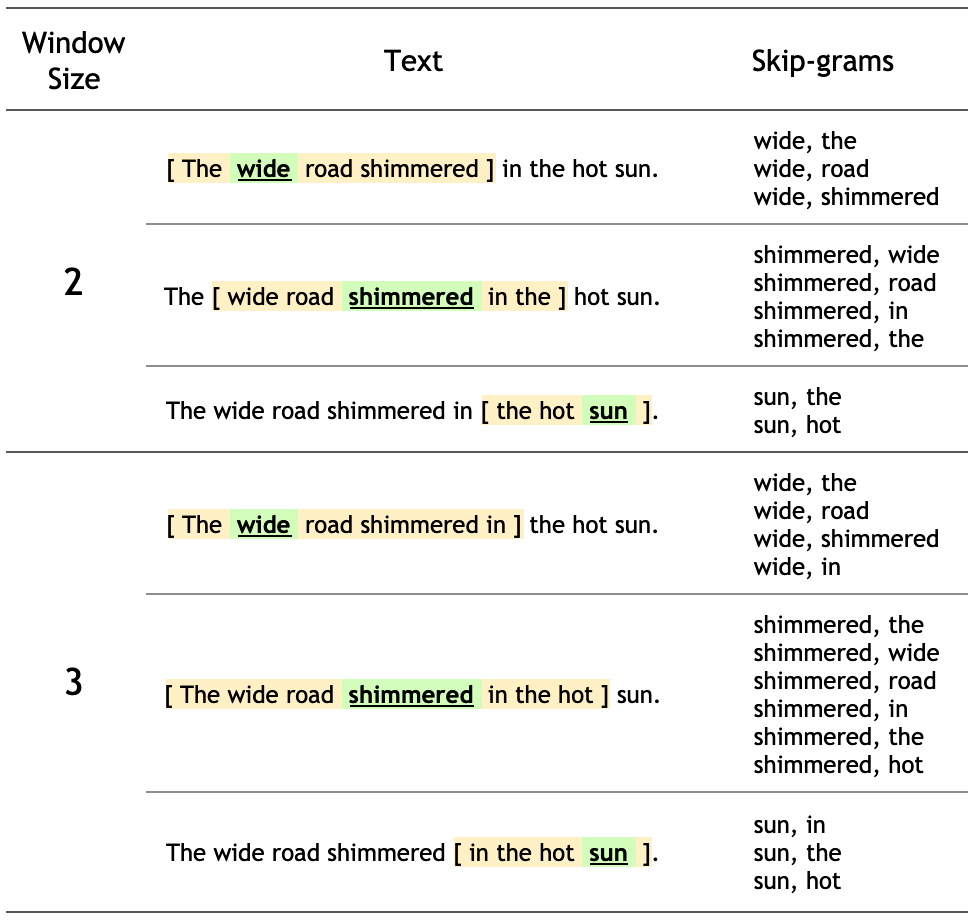

### Objective of word emediding 
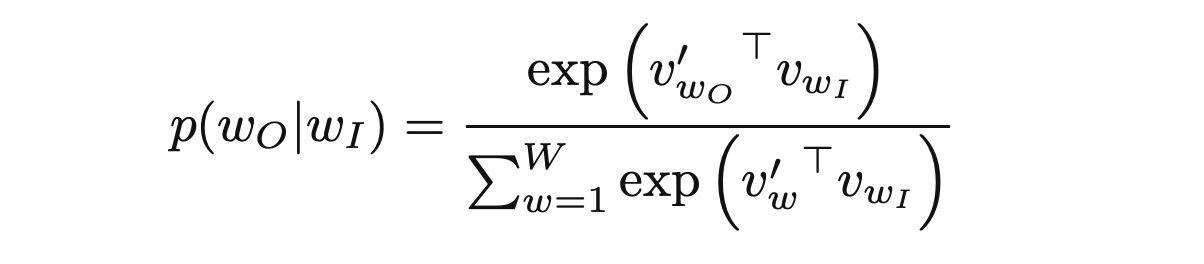